In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cellrank.kernels import TransportMapKernel
from cellrank.estimators import GPCCA
from typing import *
from anndata import AnnData, read
import scanpy as sc
import scvelo as scv
import lineageot
import pickle
import copy
import warnings
import numpy as np

In [3]:
with open("tmat_dict.pickle", "rb") as fin:
    tmats = pickle.load(fin)
tmats = {tuple(map(int, k.split("-"))): v for k, v in tmats.items()}
tmats.keys()

dict_keys([(170, 210), (210, 270), (270, 330), (330, 390), (390, 450)])

In [4]:
adata = read("/opt/projects/helmholtz/moscot/notebooks/data/filtered.h5ad")
assert len(set(adata.var['gene_short_name'])) == adata.n_vars
adata.var_names = adata.var.pop("gene_short_name")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage'
    var: 'Unnamed: 0', 'id'

In [5]:
with open("/opt/projects/helmholtz/moscot/notebooks/data/packer_pickle_lineage_tree.p", 'rb') as file:
    full_reference_tree = pickle.load(file)

In [6]:
adata = adata[adata.obs['lineage'].to_numpy() == adata.obs['random_precise_lineage'].to_numpy()].copy()
adata

AnnData object with n_obs × n_vars = 5123 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage'
    var: 'Unnamed: 0', 'id'

In [7]:
adata.obs.index = adata.obs['cell']
adata = adata[adata.obs.index.sort_values()].copy()
# for some reason on linux we need to redo this
# possibly due to version change of anndata (or dependencies)
# it seems that the previous indexing changed the index
adata.obs.index = adata.obs['cell']

In [8]:
def assign_time_to_bin(bin_string):
    if bin_string == '< 100':
        return 75
    elif bin_string == '> 650':
        # arbitrary choice here
        return 700
    else:
        # end of time range
        return (0*int(bin_string[0:3]) + 1*int(bin_string[-3:]))
    return


def remove_unlisted_leaves(tree, kept_leaves, max_depth = 10):
    """
    Removes all leaves not listed in kept_leaves from the tree
    """
    
    for i in range(max_depth):
        all_leaves = lineageot.inference.get_leaves(tree, include_root = False)
        for leaf in all_leaves:
            if not leaf in kept_leaves:
                tree.remove_node(leaf)


def create_lineage_tree(adata, batch_time, reference_tree = full_reference_tree, obsm_key = 'X_pca'):
    selected_cells = adata[adata.obs['assigned_batch_time'] == batch_time]
    
    # no need to remove any nodes from the reference
    # (unobserved subtrees have no effect on the inference)
    new_tree = copy.deepcopy(full_reference_tree)
    
    bad_cell_list = []
    good_cell_list = []
    for cell in selected_cells.obs.index:
        cell_label = selected_cells.obs['random_precise_lineage'][cell]
        cell_index = adata.obs.index.get_loc(cell)
        
        parent = next(reference_tree.predecessors(cell_label))
        
        if batch_time <= new_tree.nodes[parent]['time']:
            warnings.warn('Nonpositive time to parent ('
                          + str(batch_time - new_tree.nodes[parent]['time'])
                          + ') encountered in batch '
                          + str(batch_time) 
                          + ' for cell ' + cell)
            bad_cell_list.append(cell)
            # filter this cell out
            continue
        else:
            good_cell_list.append(cell)
        
        new_tree.add_node(cell)
        new_tree.add_edge(parent, cell)
        
        new_tree.nodes[cell]['name'] = cell_label
        new_tree.nodes[cell]['time'] = batch_time
        new_tree.nodes[cell]['time_to_parent'] = batch_time - new_tree.nodes[parent]['time']
        # new_tree.nodes[cell]['cell'] = lineageot.simulation.Cell(adata.obsm[obsm_key][cell_index, :], cell_label)
        
        assert(new_tree.nodes[cell]['time_to_parent'] >= 0)
        
        
    return new_tree, good_cell_list, bad_cell_list


def is_ancestor(late_cell, early_cell):
    if not late_cell[-1] in 'aplrdvx':
        warnings.warn('Ancestor checking not implemented for cell ' + late_cell + ' yet.')
        return
    else:
        return early_cell in late_cell


def ground_truth_coupling(early_tree, late_tree, early_cells, late_cells):
    n_early = len(early_cells)
    n_late = len(late_cells)
    coupling = np.zeros([n_early, n_late])
    for c_early, i in zip(early_cells, range(n_early)):
        for c_late, j in zip(late_cells, range(n_late)):
            if is_ancestor(late_tree.nodes[c_late]['name'],
                           early_tree.nodes[c_early]['name']):
                coupling[i, j] = 1
    
    # filter out zero rows and columns
    kept_early_cells = np.where(np.sum(coupling, 1) > 0)[0]
    kept_late_cells = np.where(np.sum(coupling, 0) > 0)[0]
    coupling = coupling[np.ix_(kept_early_cells, kept_late_cells)]
    
    
    # normalize to uniform marginal on late cells
    coupling = np.dot(coupling, np.diag(np.sum(coupling, 0)**(-1)))/len(kept_late_cells)
    
    return coupling, kept_early_cells, kept_late_cells
    

In [9]:
# If you would like to save time by only running the evaluation
# on a subset of the cells, change num_subbatches to an integer larger than 1.

# randomly splitting each batch into subbatches 
# so that there are fewer cells and the evaluation runs faster
num_subbatches = 1
adata.obs['assigned_batch_time'] = adata.obs['embryo.time.bin'].map(lambda x: assign_time_to_bin(x)
                                                                   + np.random.randint(num_subbatches))

In [10]:
batches = adata.obs['assigned_batch_time'].unique()
batches = np.sort(batches)
print(batches)

[ 75 130 170 210 270 330 390 450 510 580 650 700]


In [11]:
trees_by_batch = [create_lineage_tree(adata, batch_time) for batch_time in batches]

<ipython-input-8-21978d8deff5>:41: UserWarning: Nonpositive time to parent (-147.0) encountered in batch 75 for cell GTGCGGTGTATGGTTC-b01
  warnings.warn('Nonpositive time to parent ('
<ipython-input-8-21978d8deff5>:41: UserWarning: Nonpositive time to parent (-52.0) encountered in batch 130 for cell TACGGATGTACCCAAT-b01
  warnings.warn('Nonpositive time to parent ('
<ipython-input-8-21978d8deff5>:41: UserWarning: Nonpositive time to parent (-2.0) encountered in batch 170 for cell ACATCAGCAATCCAAC-r17
  warnings.warn('Nonpositive time to parent ('
<ipython-input-8-21978d8deff5>:41: UserWarning: Nonpositive time to parent (-12.0) encountered in batch 170 for cell ATCTGCCAGGCATTGG-r17
  warnings.warn('Nonpositive time to parent ('
<ipython-input-8-21978d8deff5>:41: UserWarning: Nonpositive time to parent (-20.0) encountered in batch 170 for cell CACTCCAAGCTGCCCA-r17
  warnings.warn('Nonpositive time to parent ('
<ipython-input-8-21978d8deff5>:41: UserWarning: Nonpositive time to parent (

In [12]:
def get_early_late_subsets(adata: AnnData, early_batch_time: int, late_batch_time: int) -> Tuple[AnnData, AnnData]:
    early_batch_index = np.where(batches == early_batch_time)[0][0]
    late_batch_index = np.where(batches == late_batch_time)[0][0]
    early_cells = trees_by_batch[early_batch_index][1]
    late_cells = trees_by_batch[late_batch_index][1]
    
    _, kept_early_cells_index, kept_late_cells_index = ground_truth_coupling(
        trees_by_batch[early_batch_index][0],
        trees_by_batch[late_batch_index][0],
        trees_by_batch[early_batch_index][1],
        trees_by_batch[late_batch_index][1]
    )
    print(early_batch_time, len(early_cells), len(kept_early_cells_index))
    print(late_batch_time, len(late_cells), len(kept_late_cells_index))
    
    return adata[early_cells][kept_early_cells_index].copy(), adata[late_cells][kept_late_cells_index].copy()

In [13]:
a1, b1 = (get_early_late_subsets(adata, 170, 210))
tmats[170, 210] = AnnData(tmats[170, 210], obs=a1.obs, var=b1.obs)
a2, b2 = (get_early_late_subsets(adata, 210, 270))
tmats[210, 270] = AnnData(tmats[210, 270], obs=a2.obs, var=b2.obs)
a3, b3 = (get_early_late_subsets(adata, 270, 330))
tmats[270, 330] = AnnData(tmats[270, 330], obs=a3.obs, var=b3.obs)
a4, b4 = (get_early_late_subsets(adata, 330, 390))
tmats[330, 390] = AnnData(tmats[330, 390], obs=a4.obs, var=b4.obs)
a5, b5 = (get_early_late_subsets(adata, 390, 450))
tmats[390, 450] = AnnData(tmats[390, 450], obs=a5.obs, var=b5.obs)

170 151 151
210 755 531
210 755 740
270 1215 1024
270 1215 1190
330 1534 1455
330 1534 1145
390 678 619
390 678 491
450 463 463


In [14]:
subsets = [
    a1,
    b1[b1.obs_names.intersection(a2.obs_names)],
    b2[b2.obs_names.intersection(a3.obs_names)],
    b3[b3.obs_names.intersection(a4.obs_names)],
    b4[b4.obs_names.intersection(a5.obs_names)],
    b5,
]

In [15]:
times = [170, 210, 270, 330, 390, 450]
for i, (t1, t2) in enumerate(zip(times[:-1], times[1:])):
    tmats[t1, t2] = tmats[t1, t2][subsets[i].obs_names, subsets[i + 1].obs_names]

In [16]:
adata = subsets[0].concatenate(subsets[1:], batch_key='time_point')
adata.obs_names = adata.obs_names.str.split("-").str[:2].str.join("-")
assert len(set(adata.obs_names)) == adata.n_obs
adata.obs['time_point'] = adata.obs['time_point'].cat.rename_categories(dict(zip(map(str, range(len(times))), times))).values
adata

AnnData object with n_obs × n_vars = 3684 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'time_point'
    var: 'Unnamed: 0', 'id'

In [17]:
sum(v.n_obs for v in tmats.values()) + b5.n_obs, len(tmats)

(3684, 5)

In [18]:
adata.obs['n_counts'] = np.array(adata.X.sum(1)).squeeze()
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = np.array((adata.X > 0).sum(1)).squeeze()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.pca(adata)#, use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
#sc.tl.umap(adata)
#sc.pl.umap(adata, color='time_point')

... storing 'time.point' as categorical
... storing 'batch' as categorical
... storing 'cell.type' as categorical
... storing 'cell.subtype' as categorical
... storing 'plot.cell.type' as categorical
... storing 'embryo.time.bin' as categorical
... storing 'raw.embryo.time.bin' as categorical
... storing 'lineage' as categorical
... storing 'random_precise_lineage' as categorical


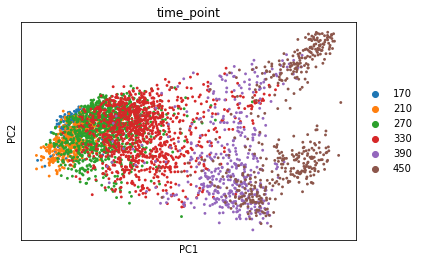

In [19]:
sc.pl.pca(adata, color='time_point')

In [20]:
class CelegansKernel(TransportMapKernel):
    def compute_transition_matrix(self, tmats: Dict[Tuple[int, int], AnnData], **kwargs: Any):
        self._tmats = tmats
        
        tmap = self._restich_tmaps(tmats, **kwargs)
        self._compute_transition_matrix(
            matrix=tmap.X,
            density_normalize=False,
            check_irreducibility=False,
        )
        return self

In [21]:
c = CelegansKernel(adata, time_key='time_point').compute_transition_matrix(tmats, last_time_point='connectivities')

  0%|          | 0/200 [00:00<?, ?sim/s]

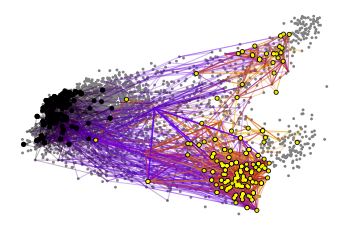

In [22]:
c.plot_random_walks(200, max_iter=20, basis='pca', start_ixs={"time_point": 170})

In [23]:
g = GPCCA(c)

In [24]:
# with more macrostates (3 or more), we also pick-up what seems to be the initial states
g.fit(2, cluster_key='cell.type')
g.predict()

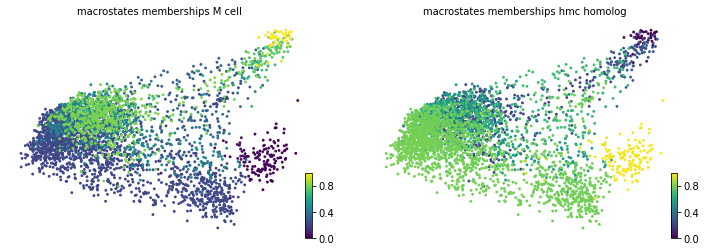

In [25]:
g.plot_macrostates(discrete=False, same_plot=False)
g.set_terminal_states_from_macrostates()

/home/michal/.miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2 [00:00<?, ?/s]

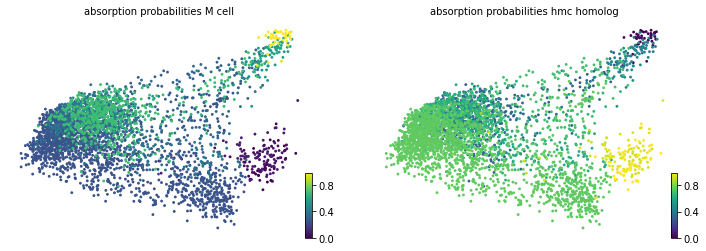

In [26]:
g.compute_absorption_probabilities()
g.plot_absorption_probabilities(same_plot=False)

In [27]:
corrs = g.compute_lineage_drivers()
corrs

/home/michal/.miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,M_cell_corr,M_cell_pval,M_cell_qval,M_cell_ci_low,M_cell_ci_high,hmc_homolog_corr,hmc_homolog_pval,hmc_homolog_qval,hmc_homolog_ci_low,hmc_homolog_ci_high
gene_short_name,,,,,,,,,,
nid-1,0.444730,5.270578e-185,NaN,0.418446,0.470270,-0.444731,5.265400e-185,NaN,-0.470270,-0.418447
mnp-1,0.422664,8.552078e-165,NaN,0.395772,0.448831,-0.422663,8.559100e-165,NaN,-0.448830,-0.395772
eef-2,0.410767,1.442033e-154,NaN,0.383561,0.437260,-0.410767,1.442035e-154,NaN,-0.437260,-0.383561
unc-62,0.380887,8.353906e-131,NaN,0.352934,0.408160,-0.380887,8.352041e-131,NaN,-0.408160,-0.352935
M28.5,0.368916,5.170646e-122,NaN,0.340681,0.396485,-0.368916,5.170145e-122,NaN,-0.396486,-0.340681
...,...,...,...,...,...,...,...,...,...,...
Y53F4B.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Y53F4B.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Y53F4B.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/michal/.miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


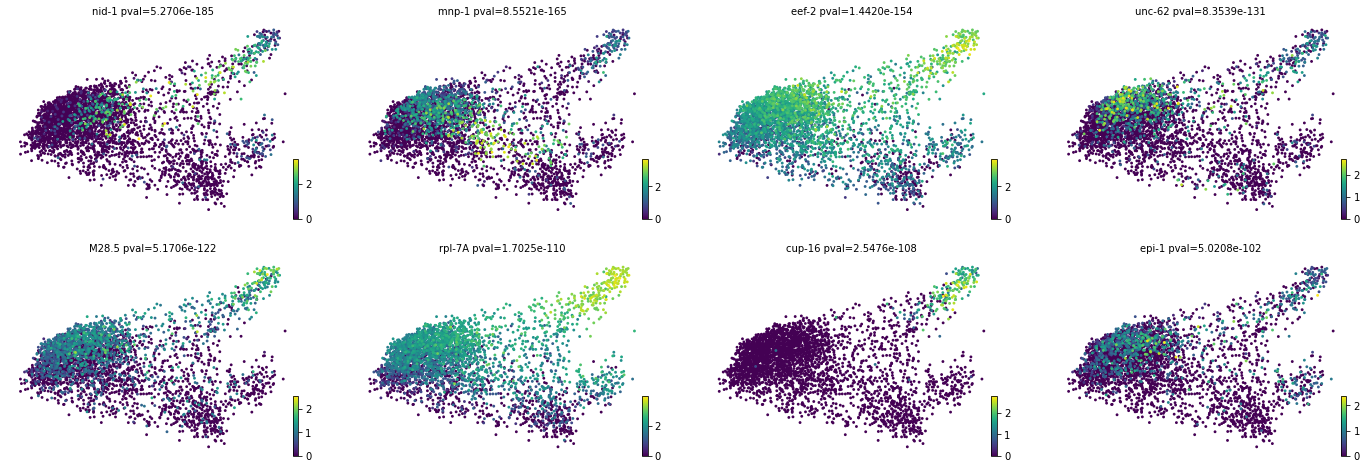

In [28]:
g.plot_lineage_drivers("M_cell", title_fmt='{gene} pval={pval:.4e}')

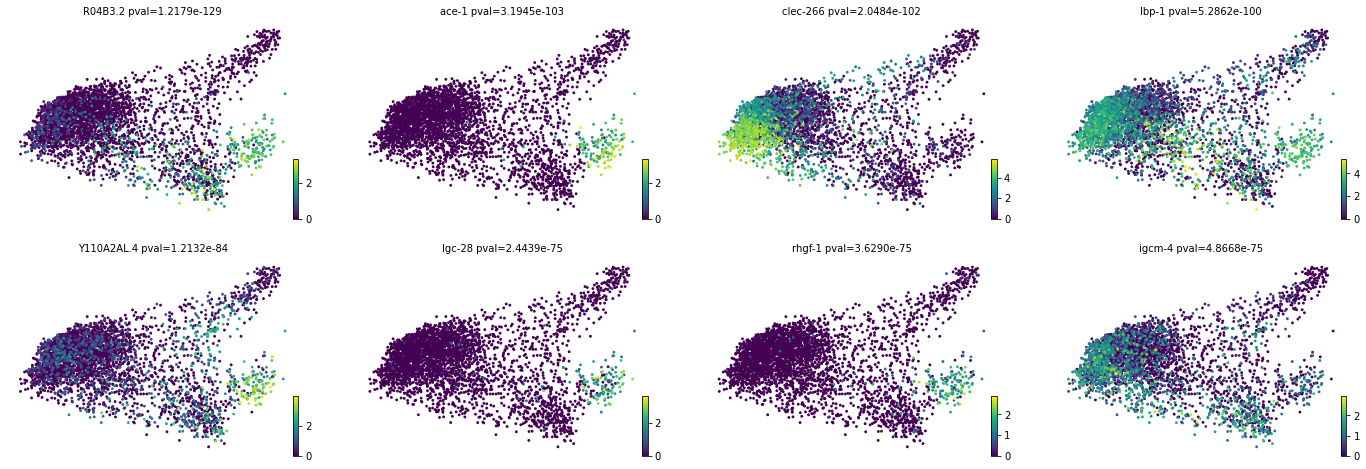

In [29]:
g.plot_lineage_drivers("hmc_homolog", title_fmt='{gene} pval={pval:.4e}')

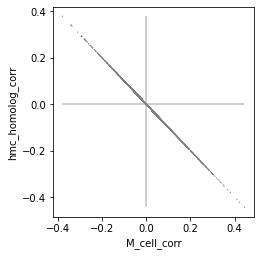

In [30]:
g.plot_lineage_drivers_correlation("M_cell", "hmc_homolog")